<a href="https://colab.research.google.com/github/febin-ch/LungCheck/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this in a code cell
!nvidia-smi


Wed Sep 10 13:10:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"draftukal","key":"44836f05cc2b5b3c0b3db5879dd83f85"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:15<00:00, 236MB/s]
100% 2.29G/2.29G [00:15<00:00, 158MB/s]


In [ ]:
!ls /content



chest_xray  drive  kaggle.json	sample_data


In [ ]:
!ls /content/chest_xray


chest_xray  __MACOSX  test  train  val


In [ ]:
!ls /content/chest_xray/train
!ls /content/chest_xray/test
!ls /content/chest_xray/val


NORMAL	PNEUMONIA
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [ ]:
import os, random, shutil

def make_small(src_root, dst_root, n_per_class=200):
    os.makedirs(dst_root, exist_ok=True)
    for cls in os.listdir(src_root):
        src = os.path.join(src_root, cls)
        if not os.path.isdir(src):
            continue
        dst = os.path.join(dst_root, cls)
        os.makedirs(dst, exist_ok=True)
        files = [f for f in os.listdir(src) if os.path.isfile(os.path.join(src,f))]
        sampled = files if len(files) <= n_per_class else random.sample(files, n_per_class)
        for f in sampled:
            shutil.copy(os.path.join(src,f), os.path.join(dst,f))

# Example: make small train and test (adjust paths if needed)
make_small('/content/chest_xray/train', '/content/chest_xray_small/train', n_per_class=200)
make_small('/content/chest_xray/test', '/content/chest_xray_small/test', n_per_class=50)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 16   # smaller for GPU memory limits; increase if you have more RAM

train_dir = '/content/chest_xray_small/train'   # or '/content/chest_xray/train' for full data
test_dir  = '/content/chest_xray_small/test'    # or '/content/chest_xray/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # important so filenames align with predictions
)

# compute class weights to help imbalance
from sklearn.utils import class_weight
classes = train_gen.classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weights = dict(enumerate(class_weights))
print("class_indices:", train_gen.class_indices)
print("class_weights:", class_weights)


Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
class_indices: {'NORMAL': 0, 'PNEUMONIA': 1}
class_weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False   # freeze for initial training

inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_resnet50.h5', monitor='val_loss', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

EPOCHS = 8   # small for demo — increase later
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early, reduce_lr],
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.5563 - auc: 0.5202 - loss: 0.8413
Epoch 1: val_loss improved from inf to 0.68929, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - accuracy: 0.5553 - auc: 0.5202 - loss: 0.8405 - val_accuracy: 0.5000 - val_auc: 0.7756 - val_loss: 0.6893 - learning_rate: 1.0000e-04
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.5109 - auc: 0.5417 - loss: 0.7604
Epoch 2: val_loss improved from 0.68929 to 0.68696, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.5111 - auc: 0.5412 - loss: 0.7606 - val_accuracy: 0.7125 - val_auc: 0.7384 - val_loss: 0.6870 - learning_rate: 1.0000e-04
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5173 - auc: 0.5244 - loss: 0.7546
Epoch 3: val_loss improved from 0.68696 to 0.68630, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 525ms/step - accuracy: 0.5175 - auc: 0.5245 - loss: 0.7544 - val_accuracy: 0.5000 - val_auc: 0.7800 - val_loss: 0.6863 - learning_rate: 1.0000e-04
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4473 - auc: 0.4137 - loss: 0.8278
Epoch 4: val_loss improved from 0.68630 to 0.68206, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.4496 - auc: 0.4178 - loss: 0.8251 - val_accuracy: 0.6625 - val_auc: 0.8266 - val_loss: 0.6821 - learning_rate: 1.0000e-04
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5155 - auc: 0.5041 - loss: 0.7493
Epoch 5: val_loss improved from 0.68206 to 0.68068, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 446ms/step - accuracy: 0.5155 - auc: 0.5043 - loss: 0.7491 - val_accuracy: 0.6125 - val_auc: 0.8091 - val_loss: 0.6807 - learning_rate: 1.0000e-04
Epoch 6/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5220 - auc: 0.5256 - loss: 0.7395
Epoch 6: val_loss improved from 0.68068 to 0.67829, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - accuracy: 0.5211 - auc: 0.5247 - loss: 0.7394 - val_accuracy: 0.7125 - val_auc: 0.8037 - val_loss: 0.6783 - learning_rate: 1.0000e-04
Epoch 7/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5161 - auc: 0.5205 - loss: 0.7190
Epoch 7: val_loss improved from 0.67829 to 0.67804, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 521ms/step - accuracy: 0.5163 - auc: 0.5205 - loss: 0.7195 - val_accuracy: 0.5000 - val_auc: 0.7816 - val_loss: 0.6780 - learning_rate: 1.0000e-04
Epoch 8/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5382 - auc: 0.5170 - loss: 0.7355
Epoch 8: val_loss improved from 0.67804 to 0.67685, saving model to best_resnet50.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 520ms/step - accuracy: 0.5371 - auc: 0.5161 - loss: 0.7357 - val_accuracy: 0.7375 - val_auc: 0.7694 - val_loss: 0.6768 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


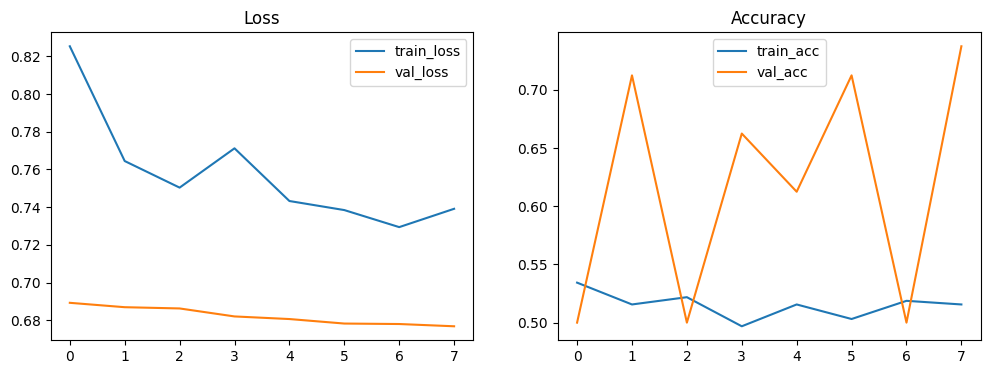

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy'); plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# predict (ensure we use enough steps)
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))
preds = model.predict(test_gen, steps=steps)
y_pred = (preds > 0.5).astype(int).ravel()
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:")
target_names = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# sensitivity/specificity:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn)>0 else 0
specificity = tn / (tn + fp) if (tn + fp)>0 else 0
print(f"Sensitivity (Recall for PNEUMONIA): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 824ms/step
Confusion matrix:
 [[44  6]
 [13 37]]

Classification report:
              precision    recall  f1-score   support

      NORMAL       0.77      0.88      0.82        50
   PNEUMONIA       0.86      0.74      0.80        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

Sensitivity (Recall for PNEUMONIA): 0.740
Specificity: 0.880


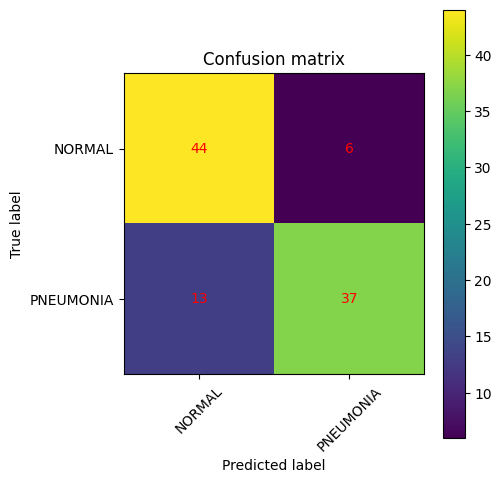

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


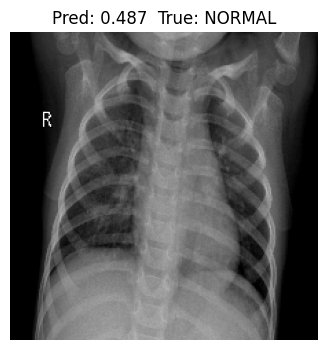

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


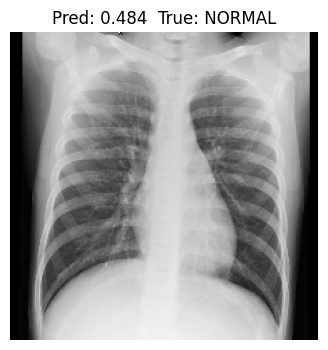

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


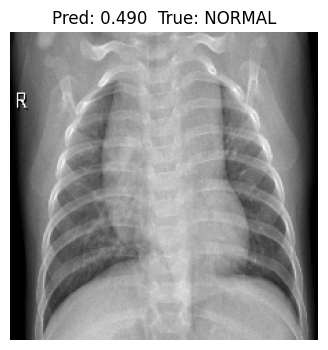

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


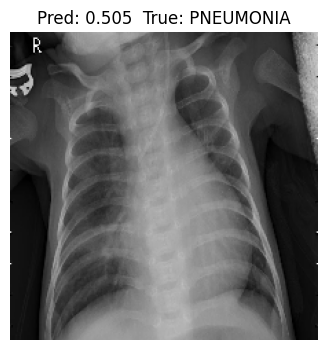

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


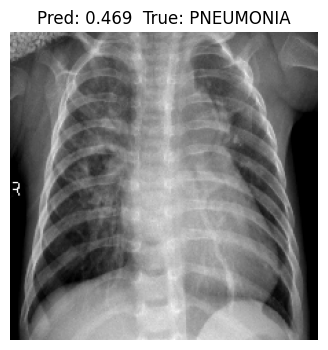

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


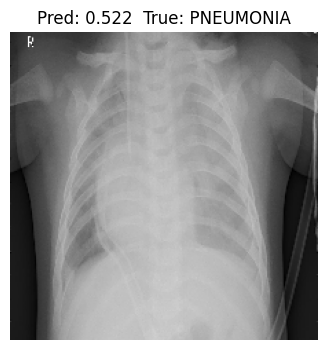

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import random

classes = ["NORMAL", "PNEUMONIA"]
n_per_class = 3   # number of images from each class to display

for cls in classes:
    # get all filenames from this class
    cls_files = [f for f in test_gen.filenames if f.startswith(cls)]

    # randomly sample some
    sampled = random.sample(cls_files, min(n_per_class, len(cls_files)))

    for fname in sampled:
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=IMG_SIZE)
        arr = image.img_to_array(img)/255.0
        prob = model.predict(np.expand_dims(arr, 0))[0][0]
        true_label = fname.split('/')[0]

        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.title(f"Pred: {prob:.3f}  True: {true_label}")
        plt.axis('off')
        plt.show()


In [ ]:
model.save("/content/drive/MyDrive/pneumonia_model.keras")
